In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split

# Ensemble Methods
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse

In [9]:
data = pd.read_csv('data/Sell-Out Data.csv', low_memory=False, thousands=',')

In [10]:
data.head()

,UNIT,DEALER,CHANNEL,SALES CHANNEL,REGION,WEEK,MONTH,QUARTER,YEAR,BRAND,CAPACITY,COMPRESSOR,COMPANY,QUANTITY
0,H-Wall,ABENSON,Modern Trade,Modern Trade,VISAYAS,Week 1-2018,Jan-18,Q1,2018,Carrier,2.0hp,Variable Speed,CSG,4
1,Wrac,ABENSON,Modern Trade,Modern Trade,VISAYAS,Week 1-2018,Jan-18,Q1,2018,Kelvinator,1.0hp,Fixed Speed,CSG,2
2,Wrac,ABENSON,Modern Trade,Modern Trade,VISAYAS,Week 1-2018,Jan-18,Q1,2018,Condura,1.0hp,Variable Speed,CSG,2
3,Wrac,ABENSON,Modern Trade,Modern Trade,VISAYAS,Week 1-2018,Jan-18,Q1,2018,Condura,1.0hp,Fixed Speed,CSG,2
4,Wrac,ABENSON,Modern Trade,Modern Trade,VISAYAS,Week 1-2018,Jan-18,Q1,2018,Condura,1.0hp,Fixed Speed,CSG,2


In [37]:
data['UNIT'].loc[data['UNIT'] == 'H-wall'] = 'H-Wall'

/Users/xmpuspus/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [41]:
data.to_csv('data/Sell-Out Data.csv', index=False)

In [42]:
pd.read_csv('data/Sell-Out Data.csv')['UNIT'].value_counts()

Wrac      274339
H-Wall     66639
PE          6546
Name: UNIT, dtype: int64

In [39]:
data.shape

(347524, 14)

In [12]:
data.dtypes

UNIT             object
DEALER           object
CHANNEL          object
SALES CHANNEL    object
REGION           object
WEEK             object
MONTH            object
QUARTER          object
YEAR              int64
BRAND            object
CAPACITY         object
COMPRESSOR       object
COMPANY          object
QUANTITY          int64
dtype: object

In [13]:
# Convert Quantity to numeric
data['QUANTITY'] = pd.to_numeric(data['QUANTITY'], errors='coerce')

# Drop empty values
data.dropna(inplace=True)

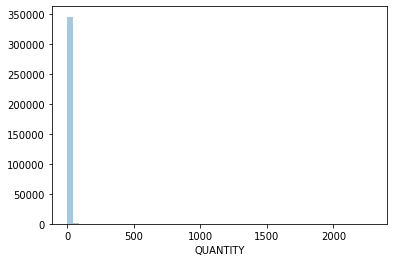

In [14]:
sns.distplot(data.QUANTITY, kde=False)

In [15]:
data.QUANTITY.describe(np.arange(0.1, 1, 0.1))

count    347524.000000
mean          4.588610
std          15.963357
min           0.000000
10%           2.000000
20%           2.000000
30%           2.000000
40%           2.000000
50%           2.000000
60%           2.000000
70%           4.000000
80%           4.000000
90%           6.000000
max        2287.000000
Name: QUANTITY, dtype: float64

In [16]:
data_quantity_quantiles = data.QUANTITY.describe(np.arange(0.01, 1, 0.01))
data_quantity_quantiles

count    347524.000000
mean          4.588610
std          15.963357
min           0.000000
1%            1.000000
             ...      
96%          15.000000
97%          38.000000
98%          38.000000
99%          38.000000
max        2287.000000
Name: QUANTITY, Length: 104, dtype: float64

In [17]:
data_quantity_quantiles['99%']

38.0

### Data Cleaning

In [18]:
# Remove 99th percentile
new_data = data[(data['QUANTITY'] <= data_quantity_quantiles['99%']) &
                (data['QUANTITY'] >= data_quantity_quantiles['1%'])]

# Retain non-competitor data
new_data = new_data[new_data['COMPANY'] != 'Competitors']

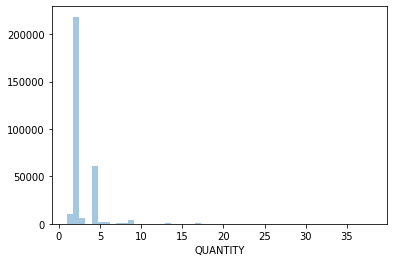

In [19]:
sns.distplot(new_data['QUANTITY'], kde=False)

### Feature Engineering

In [20]:
# Get Features
features = new_data.drop(['QUANTITY', 'YEAR', 'WEEK', 'MONTH', 'QUARTER', 'YEAR'], axis=1)

# Dummify
X = pd.get_dummies(features)

# Get Targets
y = new_data['QUANTITY']

In [21]:
X.shape, y.shape

((306575, 89), (306575,))

### Modelling

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
# model = GradientBoostingRegressor(n_estimators=300, random_state=42)

# Fit Model
%time model.fit(X_train, y_train)

CPU times: user 1min 13s, sys: 398 ms, total: 1min 13s
Wall time: 1min 14s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

### Feature Importances

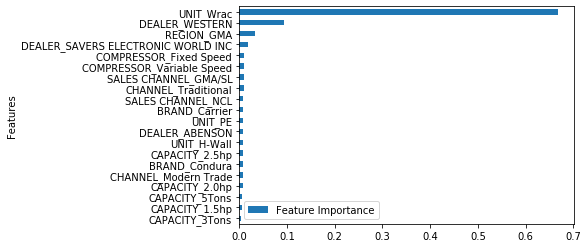

In [23]:
feature_importances_df = pd.DataFrame({"Features": X.columns,
                                       "Feature Importance": model.feature_importances_}
                                     ).sort_values('Feature Importance', ascending=False).set_index('Features')

# Top 20 Features
feature_importances_df[:20].plot(kind='barh')
plt.gca().invert_yaxis()

In [38]:
data.UNIT.value_counts()/data.UNIT.shape[0]

Wrac      0.789410
H-Wall    0.191754
PE        0.018836
Name: UNIT, dtype: float64

### RMSE

In [25]:
# Train Predictions
y_pred_train = model.predict(X_train).astype(int)

# Test Predictions
y_pred = model.predict(X_test).astype(int)

# Train RMSE
rmse_score_train = np.sqrt(mse(y_pred_train, y_train))

# Test RMSE
rmse_score = np.sqrt(mse(y_pred, y_test))

In [26]:
rmse_score, rmse_score_train

(1.4512941076738826, 1.395739138814634)

RMSE is pretty good.

### Compare Predictions from Actual Price

In [27]:
prediction_real_df = pd.DataFrame({"Real Sales Quantity": y_test, "Predicted Sales Quantity": y_pred})

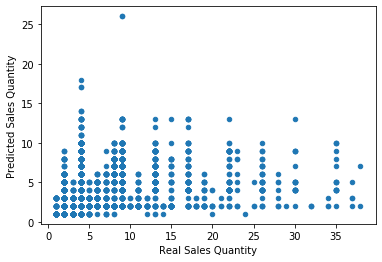

In [28]:
prediction_real_df.plot.scatter('Real Sales Quantity', 'Predicted Sales Quantity')

Predictions are pretty conservative, meaning, they are generally predicting low sale count.

### Another Metric

In [29]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [30]:
mape = mean_absolute_percentage_error(y_test, y_pred)
mape

5.59882993413348

### Save Model

In [33]:
import joblib

In [34]:
joblib.dump(model, 'model/cortex_model.sav')

['model/cortex_model.sav']

In [31]:
X_train.head()

,UNIT_H-Wall,UNIT_PE,UNIT_Wrac,DEALER_ABENSON,DEALER_ADDESSA CORPORATION,DEALER_ALL HOME,DEALER_ALSON-JAYSON,DEALER_ANSON'S,DEALER_APPLIANCE CENTRUM GROUP,DEALER_ASIAN HOME GROUP,...,CAPACITY_2.5hp,CAPACITY_3.0hp,CAPACITY_3Tons,CAPACITY_4Tons,CAPACITY_5Tons,CAPACITY_7.5Tons,CAPACITY_9Tons,COMPRESSOR_Fixed Speed,COMPRESSOR_Variable Speed,COMPANY_CSG
78939,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
130028,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
320944,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
84427,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
283320,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1


In [32]:
features

,UNIT,DEALER,CHANNEL,SALES CHANNEL,REGION,BRAND,CAPACITY,COMPRESSOR,COMPANY
0,H-Wall,ABENSON,Modern Trade,Modern Trade,VISAYAS,Carrier,2.0hp,Variable Speed,CSG
1,Wrac,ABENSON,Modern Trade,Modern Trade,VISAYAS,Kelvinator,1.0hp,Fixed Speed,CSG
2,Wrac,ABENSON,Modern Trade,Modern Trade,VISAYAS,Condura,1.0hp,Variable Speed,CSG
3,Wrac,ABENSON,Modern Trade,Modern Trade,VISAYAS,Condura,1.0hp,Fixed Speed,CSG
4,Wrac,ABENSON,Modern Trade,Modern Trade,VISAYAS,Condura,1.0hp,Fixed Speed,CSG
...,...,...,...,...,...,...,...,...,...
347519,Wrac,IMPERIAL APPLIANCE,Traditional,VIS,SOUTH LUZON,Carrier,0.5hp,Fixed Speed,CSG
347520,Wrac,IMPERIAL APPLIANCE,Traditional,VIS,SOUTH LUZON,Carrier,1.0hp,Fixed Speed,CSG
347521,Wrac,IMPERIAL APPLIANCE,Traditional,VIS,SOUTH LUZON,Carrier,1.0hp,Fixed Speed,CSG
347522,Wrac,IMPERIAL APPLIANCE,Traditional,VIS,SOUTH LUZON,Carrier,1.0hp,Fixed Speed,CSG


In [45]:
# Education Level
unit_values = pd.Series(data['UNIT'].unique()).str.strip()
unit_dummies = pd.get_dummies(unit_values)

# unit_sample = st.sidebar.selectbox("AC Unit", unit_values.values.tolist())

unit_sample_dummies = (unit_dummies.loc[np.where(unit_values.values == 'H-Wall')[0]]
                                  .values.tolist()[0])

In [43]:
unit_dummies

,H-Wall,H-wall,PE,Wrac
0,1,0,0,0
1,0,0,0,1
2,0,0,1,0
3,0,1,0,0


In [47]:
unit_sample_dummies + unit_sample_dummies

[1, 0, 0, 1, 0, 0]